# Manually Implement K-Nearest Neighbours (KNN) from Scratch

> A manual implementation of the <a href="https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm">K-Nearest Neighbours algorithm</a> for <a href="https://en.wikipedia.org/wiki/Classification">classification</a> problems in <a href="https://en.wikipedia.org/wiki/Machine_learning">machine learning</a>.
- toc: true
- badges: true
- comments: true
- sticky_rank: 1
- categories: [ml-algorithm-from-scratch, knn, nearest-neighbours, machine-learning, python]

In [1]:
#hide
from collections import Counter
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.ticker import FuncFormatter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_classification
from sklearn.metrics import DistanceMetric, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [2]:
#hide
sns.set_context("talk")

## Background

The K-Nearest Neighbours (KNN) algorithm is a statistical technique for finding the `k` samples in a dataset that are closest to a new sample that is not in the data. The algorithm can be used in both classification and regression tasks. In order to determine the which samples are closest to the new sample, the Euclidean distance is commonly used. KNN has been used in machine learning in some computer vision tasks such as recognizing hand-written numbers.

## Goal

Here, we will go through the manual implementation of this algorithm using Python. Then, we'll use it to perform binary machine learning (ML) classification on a synthetic dataset. Finally, we will compare the performance of this manual implementation of the algorithm to the version that is provided by the `scikit-learn` Python library.

## Overview of how the KNN algorithm works for ML binary classification

Since the KNN algorithm will be used in an ML classification context, we will make the following assumptions
- we can divide our data into two splits, a training split and a testing split
  - for each row (observation, or `X` matrix) in the training split, we have the associated class label (or `y`)
  - class labels are not required for observations in the test split
- for simplicity, we will be working with a binary classification problem so our data will only have two labels (0, or `False`, and 1, or `True`)

With the above assumption in mind, below is an outline of the working of KNN for ML classification
1. We start by calculating the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance#Higher_dimensions) between each new observation (test data) that is not part of the training data and the training data. In an ML workflow, this means our ML model training will not actually perform any operations since the distance calculation is only left to the prediction phase when we have access to these new observations.
2. For each point in the new observations, we sort the distances to all the points in the training data.
3. Get the `k` shortest distances from a given point in the test data to every point in the training data.
4. From these `k` distances for a single test data point, get the corresponding `k` training data points.
5. Per our assumptions, we have class labels for all training data points. So, we will assign a label to a given test data point based on the most common label in the `k` closest training data points found in 4. above. As an example if `k` is 3 then and two of the three closest training data points (to a given test data point) have a class label `1`, then the predicted class label for that test data point will also be `1`.

## Manual Implementation of KNN

In order to implement this algorithm, we'll create a custom class which accepts only one input parameter - the number of nearest neighbours (`k`) - in its `__init__` method. We'll be following the `scikit-learn` API, so we'll inherit from `scikit-learn`'s `BaseEstimator` and, since we will be using this with a classification problem, `ClassifierMixin` base classes.

```python
class CustomKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5):
        self.k = k
```

As mentioned above, explicit training is not required for KNN. So, there is nothing to do during training of the algorithm. However, we do want to follow the assumption we made earlier that our training data is clearly separated from our testing data. Since only the training data is used during ML model training, we'll assign the data that can be accessed by the `.fit()` method (i.e. ML model training) to be the training observations (`X_train`) and training class labels (`y_train`). This way, when using the KNN algorithm to make predictions on new observations, we can refer back to these variables (`X_train` and `y_train`) and know that they exclude the new observations for which we want to predict class labels. These two variables will only exist after the `.fit()` method has been called, so trying to make predictions without first training the ML model (in this case, identifying the training data) will fail.

```python
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
```

It is during prediction of the class labels that the KNN algorithm does its work. So, in our class' `.predict()` method, we'll implement the above details of this algorithm. We'll iterate over each new (test) data point and then call a helper function `make_single_prediction()` that does the following
1. calculate Eulidean distance between the selected test data point and all training data points
2. find the `k` shortest distances
3. get the corresponding training data class labels for each of the `k` shortest distances
   - these will be the labels for the `k` training data points closest to the selected test data point
4. return the most commonly occuring training data label, among the `k` closest training data points, as the predicted label for the selected test data point

This process will be repeated for all other test data points.

The Python code to implement this is shown below, with comments indicating the code for each of these four steps

```python
def get_euclidean_distance(array_1, array_2):
    # built-in approach
    dist = DistanceMetric.get_metric("euclidean")
    X = [array_1, array_2]
    dist_matrix = dist.pairwise(X)
    # # Manual approach
    # dist_manual = np.sqrt(np.sum((array_1 - array_2) ** 2))
    # assert dist_manual == dist_matrix[0, 1]
    return dist_matrix[0, 1]


def use_probabilities_to_get_labels(y_train_labels, threshold=0.5):
    y_pred_proba = np.mean(y_train_labels)
    y_pred = 0 if y_pred_proba < threshold else 1
    return y_pred


@staticmethod
def make_single_prediction(X_test, X_train, y_train, k):
    # 1. Compute distances between x and all examples in the training set
    distances = [get_euclidean_distance(X_test, X_train) for X_train in X_train]
    # 2. Sort by distance and return indices of the first k neighbors
    k_idx = np.argsort(distances)[:k]
    # 3. Extract the labels of the k nearest neighbor training samples
    # y_train_k_neighbour_labels = [y_train[i] for i in k_idx]
    y_train_k_neighbour_labels = y_train[k_idx]
    # 4. return the most common class label
    # # without using probabilities
    y_pred = Counter(y_train_k_neighbour_labels).most_common(1)[0][0]
    # # (optional) using probabilities
    y_pred = use_probabilities_to_get_labels(y_train_k_neighbour_labels, 0.5)
    return y_pred

def predict(self, X):
    y_pred = np.array(
        [
            self.make_single_prediction(obs, self.X_train, self.y_train, self.k)
            for obs in X
        ]
    )
    return y_pred
```

where
- `get_euclidean_distance()`
  - calculate Euclidean distance between two points)
- `use_probabilities_to_get_labels()`
  - convert prediction probabilities into hard labels using a user-adjustable discrimination threshold of 0.5

are standalone Python functions while `make_single_prediction()` is a static method ([1](https://www.programiz.com/python-programming/methods/built-in/staticmethod), [2](https://docs.python.org/3/library/functions.html#staticmethod)) for our `CustomKNN` class.

The final custom KNN class and commented versions of the two standalone functions are shown below

In [3]:
def get_euclidean_distance(array_1, array_2):
    # built-in approach
    dist = DistanceMetric.get_metric("euclidean")
    X = [array_1, array_2]
    dist_matrix = dist.pairwise(X)
    # # Manual approach
    # dist_manual = np.sqrt(np.sum((array_1 - array_2) ** 2))
    # assert dist_manual == dist_matrix[0, 1]
    return dist_matrix[0, 1]


def use_probabilities_to_get_labels(y_train_labels, threshold=0.5):
    # get average of training labels
    y_pred_proba = np.mean(y_train_labels)
    # assign test labels by comparing average label value to threshold
    y_pred = 0 if y_pred_proba < threshold else 1
    return y_pred

In [4]:
class CustomKNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=5, threshold=None):
        self.k = k
        self.threshold = threshold

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y


    @staticmethod
    def make_single_prediction(test_obs_indx, X_test_obs, X_train, y_train, k, threshold=None):
        # 1. Compute distances between x and all examples in the training set
        distances = [get_euclidean_distance(X_test_obs, X_train) for X_train in X_train]
        
        # 2. Sort by distance and return indices of the first k neighbors
        k_idx = np.argsort(distances)[:k]
        
        # 3. Extract the labels of the k nearest neighbor training samples
        y_train_k_neighbour_labels = y_train[k_idx]
        
        # 4. return the most common class label
        if not threshold or len(set(y_train)) > 2:
            # without using probabilities (binary or multi-class)
            y_pred = Counter(y_train_k_neighbour_labels).most_common(1)[0][0]
        else:
            # using probabilities (binary only)
            y_pred = use_probabilities_to_get_labels(
                y_train_k_neighbour_labels, threshold
            )
        return [test_obs_indx, y_pred]


    def predict(self, X):
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (
            delayed(self.make_single_prediction)(
                idx, test_obs, self.X_train, self.y_train, self.k
            )
            for idx, test_obs in enumerate(X)
        )
        y_pred = np.array(executor(tasks))

        # sort by index (first column) to ensure same index as X, and
        # get extract second column (labels)
        y_pred = y_pred[np.argsort(y_pred[:, 0])][:, 1]
        return y_pred

Two changes has been made to the above class
- as an alternative to taking the most commonly occuring label among the the `k` closest training data labels, we could calculate the average value of the `k` training labels and compare this to a threshold (for example, 0.5). If the average value is less than 0.5 then we will assign 0, otherwise we'll asisgn 1.
  - in the class, this is done if a threshold is specified as the `threshold` input parameter
- the iteration over each observation in the test data is parallelized to reduce the time required to run the algorithm

## Using the manual KNN implementation with data

In order to compare this algorithm to the version provided by `scikit-learn`, we'll generate 15,000 observations of synthetic classification data with `scikit-learn`'s `make_classification()` data generator. We'll specify that 10 columns are to be creaed, nine of which are useful for predecting the binary class labels

In [5]:
nrows = 15_000
n_feats = 10
n_informative_feats = 9
noise_factor = 30
flip_y = 0.4

In [6]:
X, y = make_classification(
    n_samples=nrows,
    n_features=n_feats,
    n_informative=n_informative_feats,
    n_redundant=0,
    n_classes=2,
    flip_y=flip_y,  # values closer to 1.0 increase difficulty of classification
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=0,
)
df_X = pd.DataFrame(X, columns=[f"var_{f_i}" for f_i in range(1, 10+1)])
s_y = pd.Series(y, name="target")

The first 10 rows of the generated dataset are shown below

In [7]:
#hide_input
display(
    df_X.head(10).assign(
        target=s_y.to_frame().head(10)
    ).style.format("{:.3f}", subset=list(df_X)).set_caption(
        "First ten rows of independent (var_*) and dependent (target) variables in the data"
    )
)

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,target
0,-1.351,-2.093,0.975,2.314,-0.542,3.762,-2.942,-0.499,-0.676,2.150,0
1,-2.368,0.212,2.423,0.135,0.249,-3.654,-0.815,1.223,0.934,-0.505,0
2,0.039,0.269,-0.502,0.205,-0.251,0.290,-2.112,0.963,-1.284,2.250,1
3,-1.890,-0.034,-0.001,3.669,-2.930,1.354,0.505,-0.614,-1.797,-1.236,1
4,-1.376,-2.345,-1.106,3.706,2.350,0.329,1.900,1.232,-1.652,-2.146,0
5,-1.286,-0.143,-0.912,0.486,-0.216,1.437,0.712,1.190,1.809,-1.286,1
6,-2.267,-0.931,1.427,2.336,-1.834,-0.845,-0.657,-3.034,0.141,1.171,0
7,-0.458,0.139,1.798,2.092,2.189,2.745,-3.283,-2.552,-2.631,1.540,0
8,-2.245,1.740,-0.322,-0.410,0.927,-1.926,1.171,2.617,1.393,-0.298,0
9,-0.264,1.967,-1.555,0.427,1.860,-1.128,-1.388,-0.714,-1.782,0.819,1


### Create training and testing splits of the overall dataset

We will split the generated data into the required training and testing splits

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

The classes in the training split from the synthetic dataset are balanced, as shown below

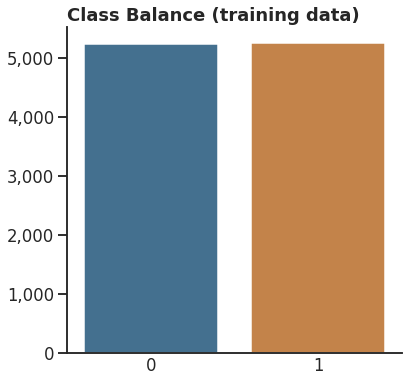

In [9]:
#hide_input
with sns.axes_style("ticks"):
    ax = sns.barplot(
        x="index",
        y=0,
        data=pd.Series(y_train).value_counts().reset_index(),
        saturation=0.5,
    )
    ax.set_title(
        "Class Balance (training data)",
        loc="left",
        fontweight="bold",
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_tick_params(length=0)
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(6)
    fig.set_figwidth(6)

So, we don't need to re-balance the data before passing it to the Random Forest algorithm.

### Feature Selection

Below is a heatmap of the feature-to-feature correlatoin between every pair of features in the synthetic data we are working with

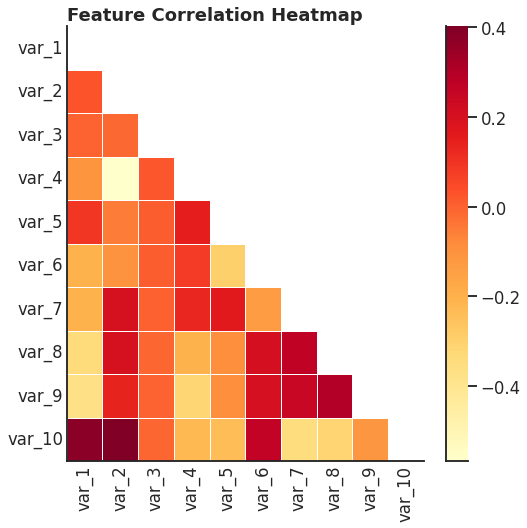

In [10]:
#hide_input
df_corr = pd.DataFrame(X_train, columns=list(df_X)).corr()
mask_ut = np.triu(np.ones(df_corr.shape)).astype(bool)

with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_corr,
        linewidths=0.5,
        cmap="YlOrRd",
        mask=mask_ut,
    )
    ax.set_title("Feature Correlation Heatmap", loc="left", fontweight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(8)

There is some evidence of multi-feature correlation which will result in KNN not working properly. In a simple case of two uncorrelated features, each contributes equally to the distance calculation. If a third feature, that is correlated to one of the existing features, is added then this feature is almost a copy of one of the other two. A combination of the two correlated features will have a greater impact on the distance, which will negatively impact accuracy of the algorithm.

A general ML-related problem with multi-feature correlation, independent of KNN, is interpreting how such features impact the output and relate to eachother.

For these two reasons, we'll drop the `var_2` which is correlated with `var_4`, `var_7`, `var_8` and `var_10`. Also, `var_6` appears to be correlated with a few features so it too can be dropped.

In [11]:
selected_cols = list(set(list(df_X)) - set(["var_2", "var_6"]))
X_train = pd.DataFrame(X_train, columns=list(df_X)).drop(columns=["var_2", "var_6"]).to_numpy()
X_test = pd.DataFrame(X_test, columns=list(df_X)).drop(columns=["var_2", "var_6"]).to_numpy()

### Pre-Processing and Making Predictions

For algorithms that depend on distance, such as KNN, including features on different scales (range from min to max) means they affect the distance differently. All the nearest neighbors (shortest distances) will be follow the feature with a smaller range, inflating their importance. To prevent this, we'll use a two-step pipeline to first normalize all features (placing them on a scale from 0 to 1) before passing them to the algorithm for classification

In [12]:
%%time
pipe_manual = Pipeline(
    [
        ("ss", MinMaxScaler()),
        ("reg", CustomKNN(k=5, threshold=0.5)),
    ]
)
pipe_manual.fit(X_train, y_train)
y_pred_manual = pipe_manual.predict(X_test)

CPU times: user 8.79 s, sys: 870 ms, total: 9.66 s
Wall time: 49.6 s


Here, the algorithm is trained on the normalized training data and then makes predictions on the testing data.

### Comparison of Predictions to Built-in Implementation

We'll again apply normalization with the built-in KNN implementation from `scikit-learn` and make predictions on the testing data

In [13]:
%%time
pipe_builtin = Pipeline(
    [
        ("ss", MinMaxScaler()),
        ("reg", KNeighborsClassifier(n_neighbors=5)),
    ]
)
pipe_builtin.fit(X_train, y_train)
y_pred_builtin = pipe_builtin.predict(X_test)

CPU times: user 264 ms, sys: 1.91 ms, total: 265 ms
Wall time: 264 ms


The first and last five rows of the testing data, including the predicted labels with the manually implemented and built-in approaches are shown below

In [14]:
#hide_input
df_pred_compare = pd.Series(y_pred_manual, name="manually_implemented_knn").to_frame().merge(
    pd.Series(y_pred_builtin, name="built_in_knn").to_frame(),
    left_index=True,
    right_index=True,
)
df_test_pred_compare = pd.DataFrame(X_test, columns=selected_cols).assign(true=y_test).merge(
    df_pred_compare,
    left_index=True,
    right_index=True,
)
display(
    df_test_pred_compare.head(5).append(df_test_pred_compare.tail(5))
    .style
    .format("{:.2f}", subset=selected_cols)
    .set_caption("First and Last 5 predictions of test split")
)

,var_3,var_10,var_7,var_8,var_4,var_9,var_5,var_1,true,manually_implemented_knn,built_in_knn
0,-1.69,1.55,1.26,1.64,-0.82,-1.61,-0.94,0.62,0,0,0
1,0.43,0.47,5.14,1.32,-1.25,0.47,-4.45,-1.15,1,1,1
2,-0.31,-0.25,1.33,-0.37,-1.86,-0.82,-1.86,3.11,1,0,0
3,-0.10,1.08,1.03,0.42,-1.00,-0.69,-0.72,1.42,1,0,0
4,-0.20,-1.56,2.14,-3.30,-1.08,0.42,-2.08,0.54,1,1,1
4495,-1.35,-1.63,1.76,-4.26,-2.49,-0.28,-4.27,-0.56,0,0,0
4496,-0.64,-0.18,-1.19,1.73,-3.63,0.59,-2.57,1.45,0,1,1
4497,0.82,-0.50,-0.86,-2.42,-2.95,-1.19,-1.20,2.00,1,1,1
4498,-1.85,0.92,-0.17,1.84,0.29,3.89,1.18,-2.13,0,0,0
4499,-2.95,0.36,2.16,5.57,-1.29,1.92,0.74,-2.31,0,0,0


It is clear that neither implementation is perfectly predicting the true class labels of the test set. But, they do appear to be performing equivalently which is encouranging. Due to the absence of the `for` loop, the built-in approach is significantly faster.

We'll explicity verify that there is no observation where a different class is predicted using the manually implemented and built-in versions of the KNN algorithm

In [15]:
df_mismatched = df_pred_compare.query("manually_implemented_knn != built_in_knn")
try:
    assert df_mismatched.empty
    print("Did not find mismatch between predictions of each implementation")
except AssertionError as _:
    print(f"Find {len(df_mismatched):,} mismatches between predictions of each implementation")

Did not find mismatch between predictions of each implementation


Below is a comparison of the number of predictions of each true label in the test set, and the predictions made with each version

In [16]:
#hide_input
df_pred_summary = pd.Series(y_test).value_counts().rename("true").to_frame().merge(
    pd.Series(y_pred_manual).value_counts().rename("manual").to_frame(),
    left_index=True,
    right_index=True,
).merge(
    pd.Series(y_pred_builtin).value_counts().rename("built-in").to_frame(),
    left_index=True,
    right_index=True,
)
display(df_pred_summary.style.set_caption("Predicted labels by class"))

,true,manual,built-in
0,2262,2320,2320
1,2238,2180,2180


This is visually shown below

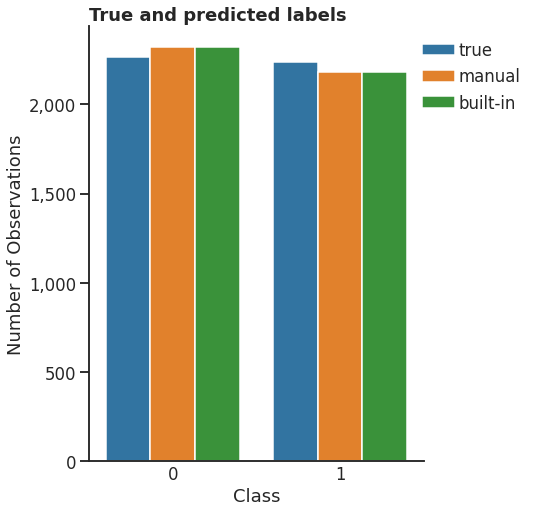

In [17]:
#hide_input
df_pred_summary_reshaped = df_pred_summary.stack().reset_index().rename(
    columns={"level_0": "class_label", "level_1": "type", 0: "count"}
)
with sns.axes_style("ticks"):
    ax = sns.barplot(
        y="count",
        x="class_label",
        hue="type",
        data=df_pred_summary_reshaped,
    )
    ax.set_title("True and predicted labels", loc="left", fontweight="bold")
    ax.set_xlabel("Class")
    ax.set_ylabel("Number of Observations")
    ax.xaxis.set_tick_params(length=0)
    ax.legend(
        ncol=1,
        loc="upper left",
        bbox_to_anchor=(0.95, 1.0),
        frameon=False,
        handletextpad=0.2,
        columnspacing=0.5,
    )
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.legend_.set_title(None)
    sns.despine()
    fig = plt.gcf()
    fig.set_figheight(8)
    fig.set_figwidth(6)

We can see that these aggregated counts of predictions for each label, with the manually implemented and built-in versions, agree with eachother.

Finally, we'll show a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix#Table_of_confusion) for each implementation

In [18]:
#hide_input
labels = pd.Index([f"class_label={label}" for label in [0, 1]], name="True")
df_cm_manual = pd.DataFrame(
    confusion_matrix(y_test, y_pred_manual), index=labels
).add_prefix("class_label=").rename_axis("Predicted", axis=1)
df_cm_builtin = pd.DataFrame(
    confusion_matrix(y_test, y_pred_builtin), index=labels
).add_prefix("class_label=").rename_axis("Predicted", axis=1)
display(df_cm_manual.style.set_caption("Confusion Matrix for manually implemented KNN"))
display(df_cm_builtin.style.set_caption("Confusion Matrix for built-in KNN"))

Predicted,class_label=0,class_label=1
True,,
class_label=0,1698,564
class_label=1,622,1616


Predicted,class_label=0,class_label=1
True,,
class_label=0,1698,564
class_label=1,622,1616


Visually, these confusion matrices are shown below

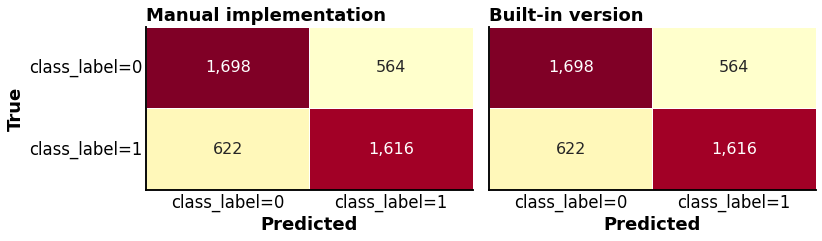

In [19]:
#hide_input
fig = plt.figure(figsize=(12, 3))
grid = plt.GridSpec(1, 2, wspace=0.05)
ax1 = fig.add_subplot(grid[0, 0], xticklabels=[])
ax2 = fig.add_subplot(grid[0, 1], xticklabels=[])

with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_cm_manual,
        linewidths=0.5,
        cmap="YlOrRd",
        annot=True,
        fmt=",d",
        cbar=False,
        ax=ax1,
        annot_kws={"size": 16},
    )
    ax.set_title("Manual implementation", loc="left", fontweight="bold")
    ax.set_xlabel("Predicted", fontweight="bold")
    ax.set_ylabel("True", fontweight="bold")
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()

with sns.axes_style("ticks"):
    ax = sns.heatmap(
        data=df_cm_builtin,
        linewidths=0.5,
        cmap="YlOrRd",
        annot=True,
        fmt=",d",
        cbar=False,
        ax=ax2,
        annot_kws={"size": 16},
    )
    ax.set_title("Built-in version", loc="left", fontweight="bold")
    ax.set_xlabel("Predicted", fontweight="bold")
    ax.set_yticklabels([])
    ax.set_ylabel(None)
    sns.despine()
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    fig = plt.gcf()

As we can see, for binary classification, the predictions of the manual KNN implementation match those of the version provided by `scikit-learn`. The off-diagonal entries (in light yellow) indicate the incorrect predictions made by the algorithm. Tuning the number of nearest neighbours to consider can possibly reduce (improve) these incorrect predictions. As the scope here was focused on implementation of the algorithm, and there is agreement between the counts in these two confusion matrices, this suggests agreement between the manual implementation and `scikit-learn`'s built-in version.

## Limitations and Resources

This was a walkthrough the implementation and use of the KNN algorithm from scratch. The focus here was on implementing the core logic of the algorithm. The version of the KNN classifier built in to `scikit-learn` offers additional functionality such as assigning the weights to points in a neighbourhood of a point of interest before selecting the `k` closest points. As al alternative to the brute force approach used here, for example, the [Ball Tree algorithm](https://en.wikipedia.org/wiki/Ball_tree) for data partitioning to improve the computation speed of `n`-point problems can be used.

From a technical perspective, the implementation here is not ideal since it involves iterating over each observation in the test data leads to a slow computation time. The built-in implementation completed nearly instantly, but our manual implementation took nearly 45 seconds for this dataset of 15,000 rows. This problem only gets worse as the number of observations in the data increase. Multi-core parallelization provides some improvement, but, regrettably, the real increase in efficiency of this manual implementation comes from completely replacing the use of loops with [vectorization](https://en.wikipedia.org/wiki/Array_programming) using the `numpy` library in Python. This is done in the built-in version of this algorithm in `scikit-learn` ([1](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors)). Future iterations of this manual implementation should focus on using vectorization to speed up the KNN model's predictions.